# Basic usage of SpinPulse

In this Jupyter notebook, we present the basic usage of the `SpinPulse` package.
We first show how to transpile a `qiskit.QuantumCircuit` into a `spin_pulse.PulseCircuit`.
We then demonstrate how to use the `.to_circuit()` method to obtain a `qiskit.QuantumCircuit` that represents the initial circuit executed on silicon-based spin qubits.
The implementation of noise at the circuit level is then presented, together with the different manipulation pulse shapes and the addition of dynamical decoupling during qubit idle times.

## Hardware Specs definition
We begin by creating an ``HardwareSpecs`` instance that specifies the parameters of our spin-qubit quantum computer.

See the `ParametrizingfromQPUSpecs` example for hardware specifications tailored to spin-qubit hardware.

In [1]:
%load_ext autoreload
%autoreload 2
import qiskit as qi

from spin_pulse.environment.noise import NoiseType
from spin_pulse.transpilation.hardware_specs import HardwareSpecs, Shape

num_qubits = 3
B_field, delta, J_coupling = 0.5, 0.2, 0.01
ramp_duration = 5
hardware_specs = HardwareSpecs(
    num_qubits, B_field, delta, J_coupling, Shape.GAUSSIAN, ramp_duration, optim=3
)

Then we specify a quantum circuit that we would like to implement and simulate.
Here the circuit is simply made of a CNOT on the first two qubits, while the third qubit remains at rest.

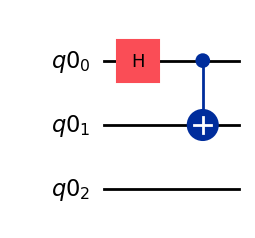

In [2]:
qreg = qi.QuantumRegister(num_qubits)
circ = qi.QuantumCircuit(qreg)

circ.h(0)
circ.cx(0, 1)
circ.draw("mpl")

## Gate transpilation

The `gate_transpile` method from the `HardwareSpecs` class converts our circuit to an ISA circuit that is composed of the native gates of the silicon-based spin qubit platform.

This step is realized through qiskit transpilers.

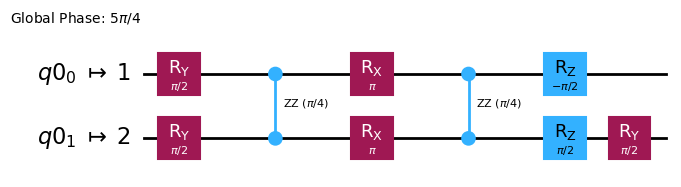

In [3]:
isa_circ = hardware_specs.gate_transpile(circ)
isa_circ.draw("mpl", filename="output2.svg")

We obtain our transpiled circuit: `isa_circ` that is formally equivalenent to the original one, i.e. they are described by the same unitary quantum channel, something that we can check using the module ``qiskit.quantum_info``:

In [4]:
from qiskit.quantum_info import Operator, average_gate_fidelity

# the transpilation process might modify the ordering between physical and logical qubits
# the function from_circuit takes into account the layout of the transpiled circuit to ensure consistent ordering
print(
    "Fidelity between circuit and ISA circuit:",
    average_gate_fidelity(Operator.from_circuit(circ), Operator.from_circuit(isa_circ)),
)

Fidelity between circuit and ISA circuit: 1.0


## Pulse transpilation

We now compute the required pulses thats implement `isa_circ` by parameterizing the Hamiltonians of the spin-qubit model to construct the circuit.

The `PulseCircuit` class performs this task based on the hardware specifications and automatically computes the pulse durations required to implement the rotation gates $R_{X,Y,Z}$ and $R_{ZZ}$ of the model.

Note that, in this example, idle times are automatically inserted to synchronize the qubits at each circuit layer.

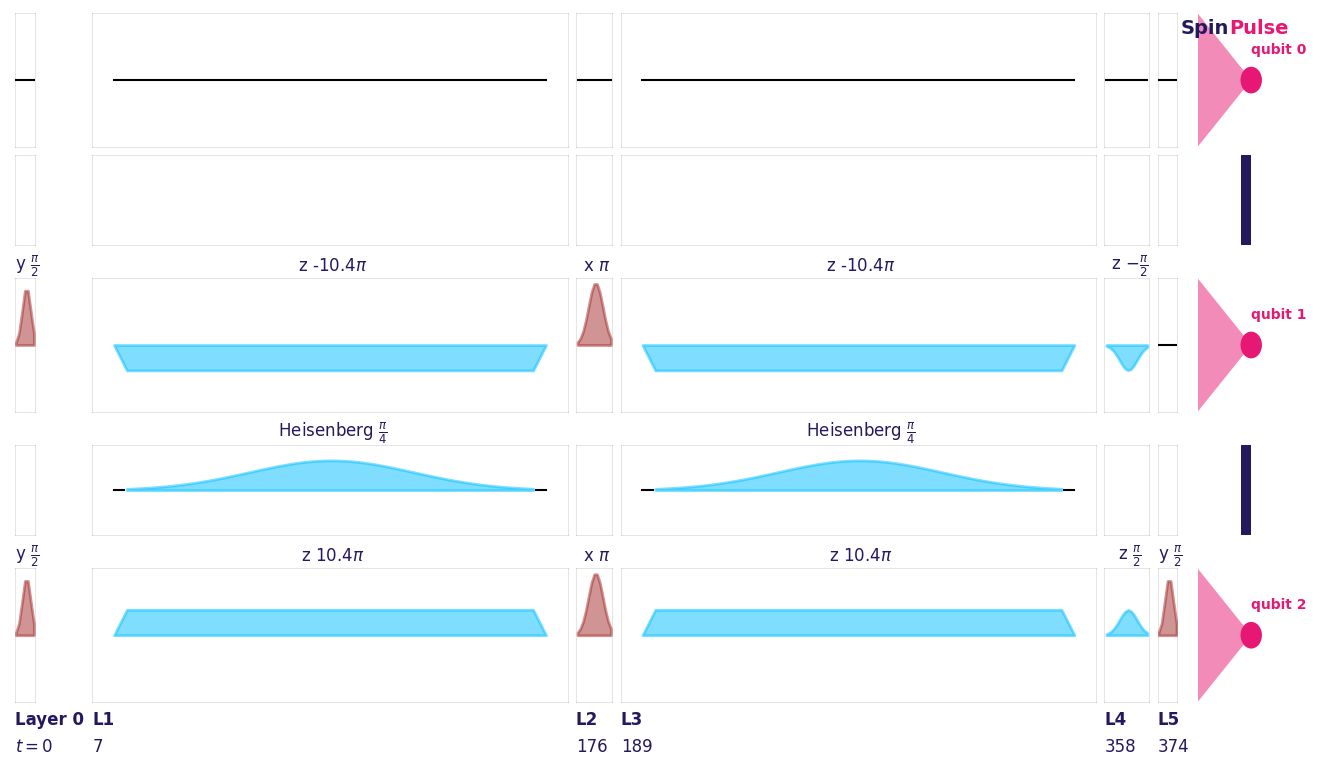

In [5]:
from spin_pulse import PulseCircuit

pulse_circuit = PulseCircuit.from_circuit(isa_circ, hardware_specs)
pulse_circuit.plot(hardware_specs=hardware_specs)


In this illustration, the red pulses correspond to single-qubit gates driven by an oscillating magnetic field, while the blue pulses correspond to two-qubit gates implemented via a $J$-coupling (Heisenberg) pulse. The delta (z) ramp defined in the gate is also shown in blue.

The pulse shapes are Gaussian for both the oscillating magnetic-field drive and the $J$-coupling pulse, as specified in the hardware configuration.

Pulse durations and amplitudes are determined from the hardware specifications provided when initializing the `HardwareSpecs` object.

## Numerical integration

The function `to_circuit` integrates these pulses to obtain the implemented circuit as a sequence of unitary matrices representing each gate. This is the standard way to represent a quantum circuit, in particular using the class qiskit's ``QuantumCircuit`` that we use here.

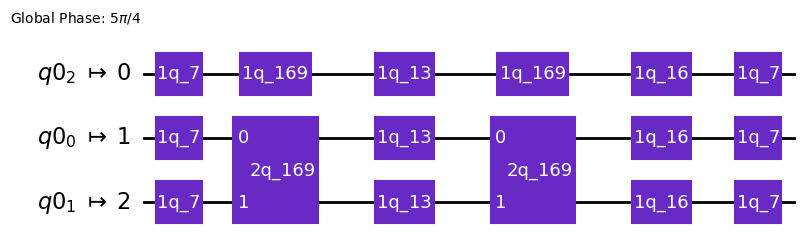

In [6]:
implemented_circ = pulse_circuit.to_circuit()
implemented_circ.draw("mpl", style="textbook", filename="output4.svg")

Having such a gate-based description allows to use qiskit functions to evaluate direclty some metrics, such as the fidelity with the original circuit.
Here the fidelity deviates from unity to the presence of small non-adiabatic contribution in the realization of the two qubit gate. We provide the function ``pulse_circuit.fidelity`` to evaluate this metric directly from the pulse circuit.

In [7]:
print(
    "Fidelity between our implemented circuit and the original circuit ",
    average_gate_fidelity(
        Operator.from_circuit(implemented_circ), Operator.from_circuit(circ)
    ),
    "\nUsing the fidelity function ",
    pulse_circuit.fidelity(),
)

Fidelity between our implemented circuit and the original circuit  0.9999996570953983 
Using the fidelity function  0.9999996570953987


## Noise-Accurate Simulations

An experimental environment can be initialized using the `ExperimentalEnvironment` class.

Here, we define the noise as `PINK`, which is an important noise characteristic of spin qubits, with a coherence time $T_2^* = 500$.

We also set the total duration of the time trace to `segment_duration = 2**15`, equal to the native time `duration = 2**15`.

For pink noise, the native duration of the time trace is crucial because it determines the frequency components present in the signal. As a result, a longer time trace exhibits larger fluctuations and has a stronger impact on the qubit evolution due to the $1/f$ power spectral density.

Attaching an experimental environment to a pulse circuit introduces noisy time traces on each qubit.



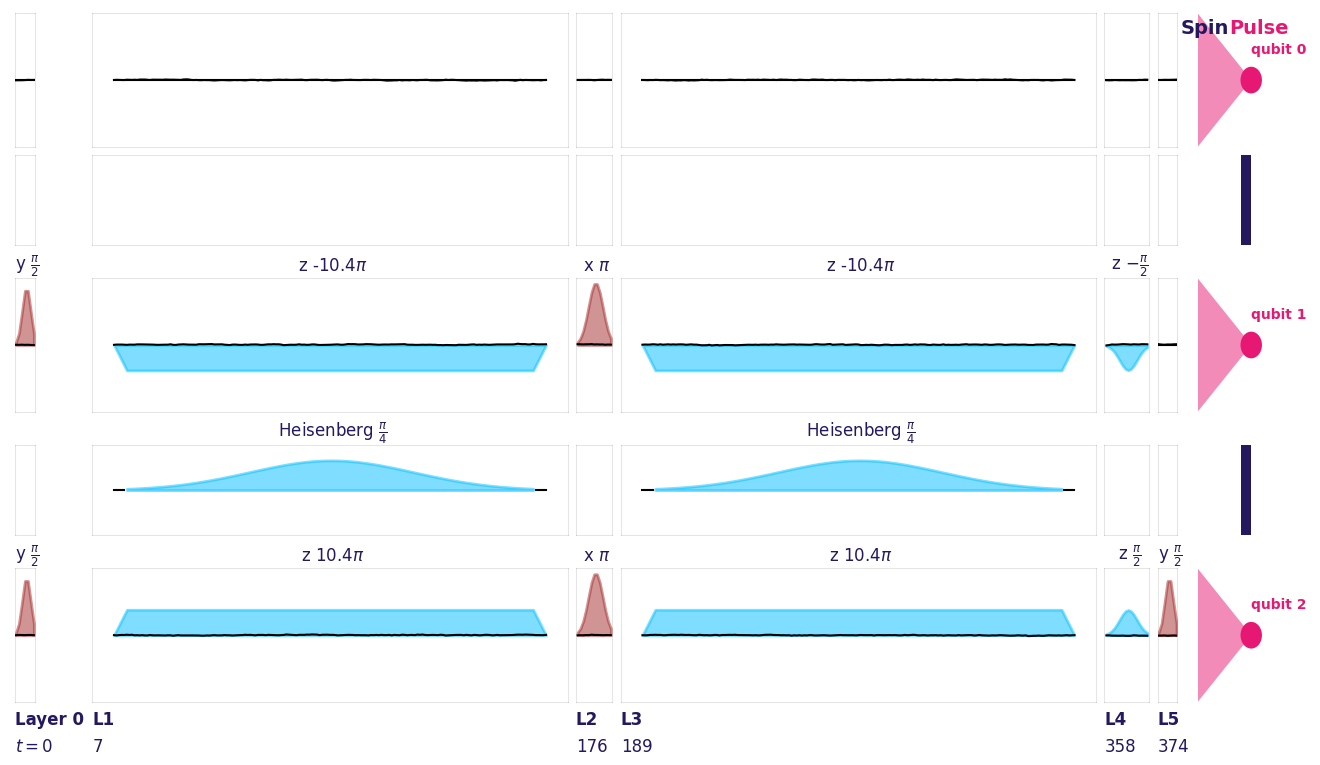

In [8]:
from spin_pulse.environment.experimental_environment import (
    ExperimentalEnvironment,
)

exp_env = ExperimentalEnvironment(
    hardware_specs=hardware_specs,
    noise_type=NoiseType.PINK,
    T2S=500,
    duration=2**15,
    segment_duration=2**15,
)
pulse_circuit_noise = PulseCircuit.from_circuit(
    isa_circ, hardware_specs, exp_env=exp_env
)
pulse_circuit_noise.plot(hardware_specs)

By averaging over multiple circuit executions within the experimental environment, we can access relevant metrics of the model, such as the mean fidelity with respect to the original circuit.


In [ ]:
print("Average circuit fidelity ", pulse_circuit_noise.mean_fidelity(exp_env))

## Switching to square pulses

Through a simple argument change, we can change the shapes of our pulses from Gaussian to Square, and repeat the same calculations.

Fidelity between our implemented circuit and the original circuit  0.9999557548862962


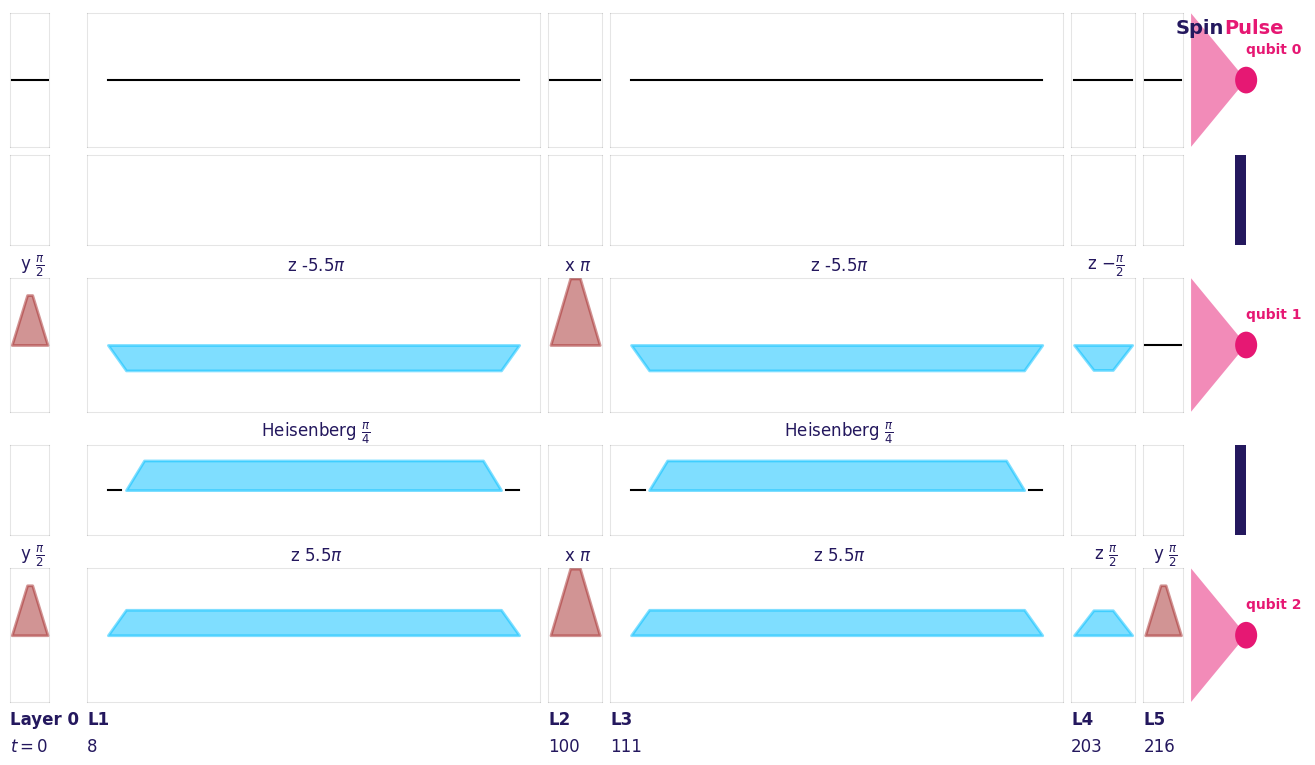

In [10]:
ramp_duration_square = 4
hardware_specs_square = HardwareSpecs(
    num_qubits, B_field, delta, J_coupling, Shape.SQUARE, ramp_duration_square
)
pulse_circuit_square = PulseCircuit.from_circuit(isa_circ, hardware_specs_square)
print(
    "Fidelity between our implemented circuit and the original circuit ",
    pulse_circuit_square.fidelity(),
)
pulse_circuit_square.plot(hardware_specs)

## Dynamical decoupling

Finally, the ``dynamical_decoupling`` optional argument in the ``HardwareSpecs`` constructor allows to replace idle sequences by single-qubit rotations, in order to protect the qubit from the low frequency part of the time traces  (the high-frequency part being still present and affecting coherence).

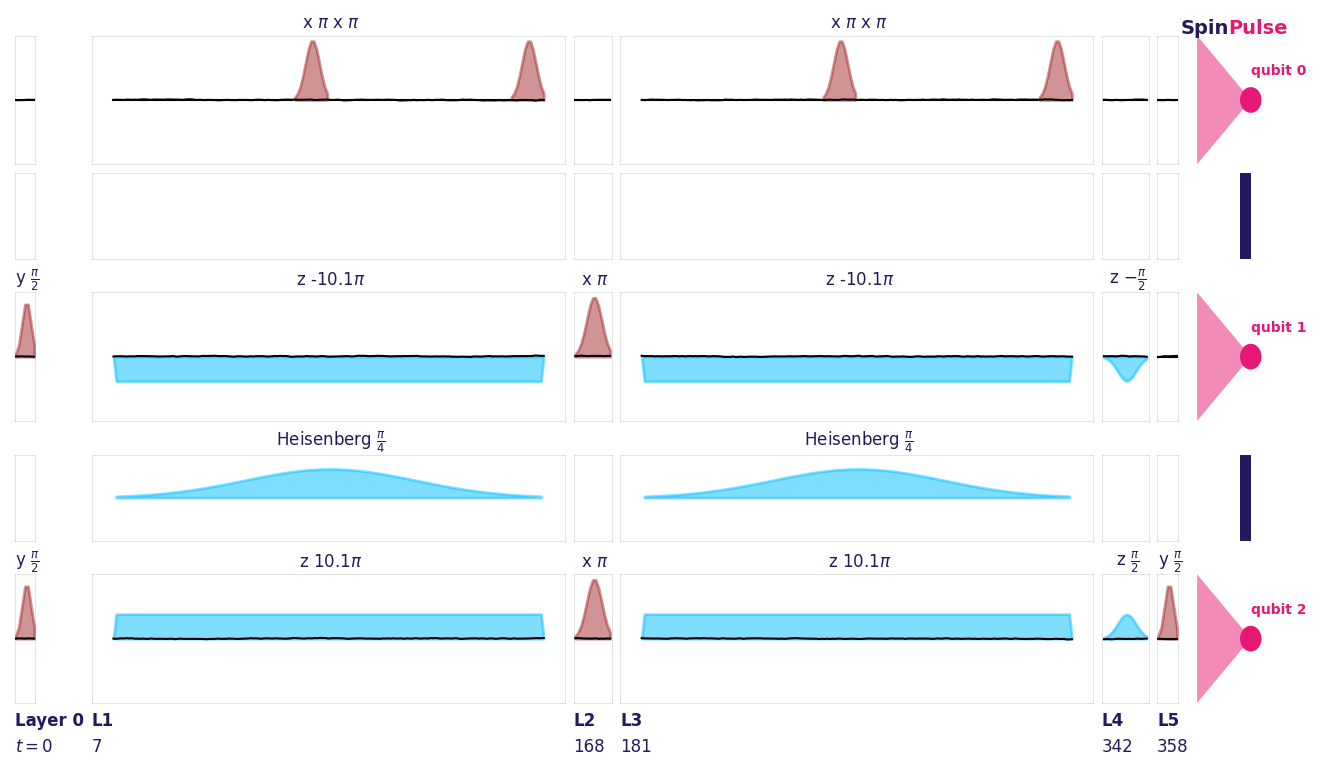

In [11]:
from spin_pulse import DynamicalDecoupling

hardware_specs_dd = HardwareSpecs(
    num_qubits,
    B_field,
    delta,
    J_coupling,
    Shape.GAUSSIAN,
    dynamical_decoupling=DynamicalDecoupling.SPIN_ECHO,
)
pulse_circuit_dd = PulseCircuit.from_circuit(
    isa_circ, hardware_specs_dd, exp_env=exp_env
)
pulse_circuit_dd.plot(hardware_specs)

We obtain a significant improvement

In [ ]:
print(
    "Average circuit fidelity without DD:",
    pulse_circuit_noise.mean_fidelity(exp_env),
)
print(
    "Average circuit fidelity with DD:",
    pulse_circuit_dd.mean_fidelity(exp_env),
)